# Alternative Tracing Methods

## LangChain and LangGraph

In [1]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv()

True

USER_AGENT environment variable not set, consider setting it to identify your requests.


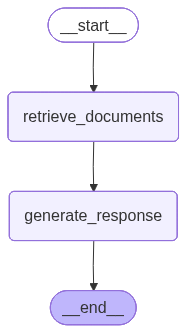

In [2]:
import nest_asyncio
import operator
from langchain.schema import Document
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils import get_vector_db_retriever, RAG_PROMPT

nest_asyncio.apply()

retriever = get_vector_db_retriever()
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Define Graph state
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

# Define Nodes
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, conversation=messages, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}

# Define Graph
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

In [11]:
question = "Why should I use tracing in LangChain?"
simple_rag_graph.invoke({"question": question}, config={"metadata": {"foo": "bar"}})

{'question': 'Why should I use tracing in LangChain?',
 'messages': [HumanMessage(content='Why should I use tracing in LangChain?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Using tracing in LangChain allows for better observability and evaluation of agentic workflows, helping you understand the performance and behavior of your applications. It enables you to log custom LLM traces, which can provide insights into token usage and cost calculations. Additionally, tracing helps in troubleshooting and optimizing your applications by visualizing the flow of data across services.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 1370, 'total_tokens': 1439, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'syst

## Tracing Context Manager

In [6]:
from langsmith import traceable, trace
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable
def retrieve_documents(question: str):
    documents = retriever.invoke(question)
    return documents

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    with trace(
        name="Generate Response",
        run_type="chain", 
        inputs={"question": question, "formatted_docs": formatted_docs},
        metadata={"foo": "bar"},
    ) as ls_trace:
        messages = [
            {
                "role": "system",
                "content": RAG_SYSTEM_PROMPT
            },
            {
                "role": "user",
                "content": f"Context: {formatted_docs} \n\n Question: {question}"
            }
        ]
        response = call_openai(messages)
        ls_trace.end(outputs={"output": response})
    return response

"""
call_openai
- Returns the chat completion output from OpenAI
"""
@traceable
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    return response

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


In [12]:
question = "What are some alternative methods of tracing in LangSmith?"
ai_answer = langsmith_rag(question)
print(ai_answer)

Alternative methods of tracing in LangSmith include using OpenTelemetry for both automatic and manual instrumentation, tracing with external applications that are compatible with OpenTelemetry, and utilizing LangChain-specific tracing features. Users can also log custom LLM traces and retriever traces to gain insights into their applications. For specific setups, integrating with the LangSmith REST API or utilizing the Vercel AI SDK are additional options available.


## wrap_openai

In [8]:
from langsmith.wrappers import wrap_openai
import openai
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

# TODO: Wrap the OpenAI Client
openai_client = wrap_openai(openai.Client())

nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    # TODO: We don't need to use @traceable on a nested function call anymore,
    # wrap_openai takes care of this for us
    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )
@traceable(run_type="chain")
def langsmith_rag_with_wrap_openai(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


In [13]:
question = "How is tracing by wrapping my OpenAI client any different from using @traceable?"
ai_answer = langsmith_rag_with_wrap_openai(question)
print(ai_answer)

Wrapping your OpenAI client allows for automatic logging of traces without needing to use decorators or modify function calls, making it simpler and more seamless. In contrast, using the @traceable decorator requires you to explicitly decorate functions to enable tracing. Both methods can be used together in the same application for enhanced trace logging.


The wrapped OpenAI client accepts all the same langsmith_extra parameters as @traceable decorated functions

In [14]:
messages = [
    {
        "role": "user",
        "content": "What is the novel 1984 by George Orwell based on? What are its underyling themes?"
    }
]

openai_client.chat.completions.create(
    model=MODEL_NAME,
    messages=messages,
    langsmith_extra={"metadata": {"foo": "bar"}},
)

ChatCompletion(id='chatcmpl-CN052gd1Hv4bq1pzYbD5n4v825DoC', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='George Orwell\'s novel "1984," published in 1949, is a dystopian narrative set in a totalitarian state that uses extreme surveillance, propaganda, and repression to control its citizens. The story follows Winston Smith, a man living in Oceania, a superstate ruled by the Party under the leadership of Big Brother. The novel explores various underlying themes that remain relevant today.\n\n### Key Themes:\n\n1. **Totalitarianism**:\n   The central theme of "1984" is the exploration of totalitarian regimes and their methods of control. The Party employs technology, psychological manipulation, and violent repression to maintain power, illustrating the dangers of a government that seeks absolute control over its citizens.\n\n2. **Surveillance and Privacy**:\n   Orwell\'s vision of a world under constant surveillance raises important 

## [Advanced] RunTree

In [16]:
from dotenv import load_dotenv
load_dotenv()

True

In [19]:
import os
os.environ["LANGSMITH_TRACING"] = "false"

from langsmith import utils
utils.tracing_is_enabled() # not sure why it keeps returning true here, i've even explicitly declared it in the env file. will check on this further.

True

We have rewritten our RAG application, except this time we pass a RunTree argument through our function calls, and create child runs at each layer. This gives our RunTree the same hierarchy that we were automatically able to establish with @traceable

In [69]:
from langsmith import RunTree
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever
load_dotenv(dotenv_path="E:/MAT496-LangSmith/.env")
api_key = os.getenv("OPENAI_API_KEY")
openai_client = OpenAI(api_key=api_key)
nest_asyncio.apply()
retriever = get_vector_db_retriever()

def retrieve_documents(parent_run: RunTree, question: str):
    # Create a child run
    child_run = parent_run.create_child(
        name="Retrieve Documents",
        run_type="retriever",
        inputs={"question": question},
    )
    documents = retriever.invoke(question)
    # Post the output of our child run
    child_run.end(outputs={"documents": documents})
    child_run.post()
    return documents

def generate_response(parent_run: RunTree, question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the latest question in the conversation. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    """
    # Create a child run
    child_run = parent_run.create_child(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "documents": documents},
    )
    messages = [
        {
            "role": "system",
            "content": rag_system_prompt
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    openai_response = call_openai(child_run, messages)
    # Post the output of our child run
    child_run.end(outputs={"openai_response": openai_response})
    child_run.post()
    return openai_response

def call_openai(
    parent_run: RunTree, messages: List[dict], model: str = "gpt-4o-mini", temperature: float = 0.0
) -> str:
    # Create a child run
    child_run = parent_run.create_child(
        name="OpenAI Call",
        run_type="llm",
        inputs={"messages": messages},
    )
    openai_response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    # Post the output of our child run
    child_run.end(outputs={"openai_response": openai_response})
    child_run.post()
    return openai_response

def langsmith_rag(question: str):
    # Create a root RunTree
    root_run_tree = RunTree(
        name="Chat Pipeline",
        run_type="chain",
        inputs={"question": question}
    )

    # Pass our RunTree into the nested function calls
    documents = retrieve_documents(root_run_tree, question)
    response = generate_response(root_run_tree, question, documents)
    output = response.choices[0].message.content

    # Post our final output
    root_run_tree.end(outputs={"generation": output})
    root_run_tree.post()
    return output
    


In [71]:
question = "How is tracing with RunTree any different from all the other methods in LangSmith?"
ai_answer = langsmith_rag(question)
print(ai_answer)

Tracing with RunTree in LangSmith allows for more granular filtering and visualization of runs based on their hierarchical structure, which can enhance the understanding of complex workflows. Unlike other methods, RunTree focuses on the relationships between runs, making it easier to analyze specific sequences of operations. This can provide deeper insights into the performance and behavior of your application compared to standard tracing methods.
